Remove warnings:

In [38]:
import warnings
warnings.filterwarnings('ignore')

Show plots inline:

In [39]:
%matplotlib inline

Parameters:

In [40]:
p = 0.95 #significance
scale = 56 #weeks per year

Custom functions:

In [41]:
def wrd_div(n, d):
    return n / d if d else 0

def est_coef(x, y): 
    n = np.size(x) 
    m_x, m_y = np.mean(x), np.mean(y) 

    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 

    k = SS_xy / SS_xx 
    b = m_y - k*m_x 
  
    return(b, k)

Import libraries:

In [42]:
from statistics import median
import statsmodels.api as sm
import statistics

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.dates as dates
import plotly.graph_objects as go

Read data:

In [43]:
labels = ['TLT', 'SPY', 'GOLD']
df = pd.ExcelFile('data/data.xlsx').parse('data')[['DATE', 'TLT', 'SPY', 'GOLD']]

Format data:

In [44]:
df = df.dropna(how='any', axis=0)
df['DATE'] =  pd.to_datetime(df['DATE']).dt.date 

Show time period and records number:

In [45]:
print('Total volume:', len(df), 'records')
print('Dates:', list(df['DATE'])[0], '=>', list(df['DATE'])[-1])

Total volume: 783 records
Dates: 2004-11-15 => 2019-11-08


Drop date feature:

In [46]:
df = df.drop(['DATE'], axis=1) 

Show monthly boxplots:

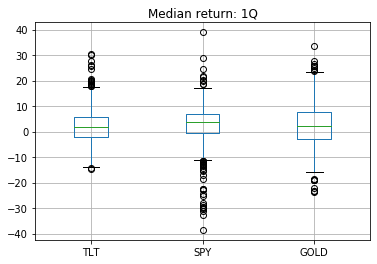

In [47]:
bp = 100*df.pct_change(periods=int(0.25*scale))
bp.boxplot(grid=True, patch_artist=False)

plt.title('Median return: 1Q')
plt.show()

Individual and portfolio metrics vice horizon:

In [48]:
df_stat, df_hor = [],[]
p_med, p_std, p_var = [], [], []

for i in range(2*scale): 
    
    df_hor.append(i/scale)
    
    df_ret = 100*df.pct_change(periods=i)
    p_ret = (1/len(df_ret.columns))*df_ret.sum(axis = 1, skipna = True)
    
    df_med = df_ret.apply(lambda x : x.median())
    df_std = df_ret.apply(lambda x : x.std())
    df_var = df_ret[df_ret <= 0].apply(lambda x : x.abs().quantile(p))
    
    p_med.append(p_ret.median())
    p_std.append(p_ret.std())
    p_var.append(np.quantile(([abs(x) for x in p_ret if x <= 0]), p))
    
    df_stat.append(pd.DataFrame({'Return': df_med, 'Standard': df_std, 'Value at risk': df_var}))

Define statistics:

In [49]:
ass_ret,ass_std,ass_var = [],[],[]

for item in range(len(df.columns)):
    
    ass_ret.append(list([float(df_stat[x]['Return'].iloc[item]) for x in range(2*scale)]))
    ass_std.append(list([float(df_stat[x]['Standard'].iloc[item]) for x in range(2*scale)]))
    ass_var.append(list([float(df_stat[x]['Value at risk'].iloc[item]) for x in range(2*scale)]))

Define annualized cumulated returns:

In [50]:
years_num = int(round(len(df)/scale))
df_cum = pd.DataFrame(round(100*(df.iloc[-1]-df.iloc[0])/df.iloc[0]))
df_annual = (df_cum.transpose()/years_num).astype('int64')

Median return vice horizon, saturation for 1/N at annual horizon:

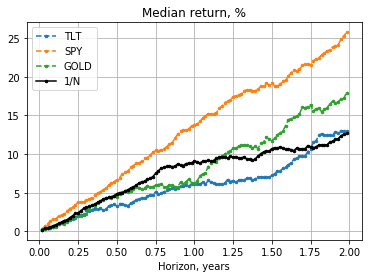

In [51]:
for i in range(len(df.columns)):
    plt.plot(df_hor[1:], ass_ret[i][1:], '.--', label=labels[i], markersize=5)

plt.plot(df_hor[1:], p_med[1:], '.-', label='1/N', color='black', markersize=5)

plt.title('Median return, %')
plt.xlabel('Horizon, years')

plt.legend(loc='upper left')
plt.grid(True)

Value at risk (95%) vice horizon:

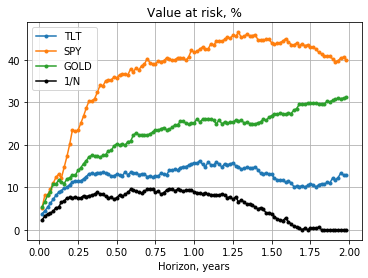

In [52]:
for i in range(len(df.columns)):
    plt.plot(df_hor[1:], ass_var[i][1:], '.-', label=labels[i])

plt.plot(df_hor[1:], p_var[1:], '.-', label='1/N', color='black')

plt.title('Value at risk, %')
plt.xlabel('Horizon, years')

plt.legend(loc='upper left')
plt.grid(True)

plt.show()

Return/Var relation:

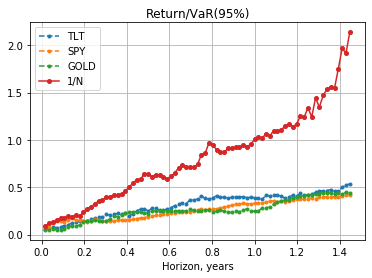

In [53]:
assets_z = []

for i in range(len(df.columns)):
    assets_z.append([wrd_div(x,y) for x, y in zip(ass_ret[i][1:], ass_var[i][1:])])
    plt.plot(df_hor[1:-30], [wrd_div(x,y) for x, y in zip(ass_ret[i][1:], ass_var[i][1:])][:-30], '.--', label=labels[i])

t = [wrd_div(x,y) for x, y in zip(p_med[1:], p_var[1:])]
    
plt.plot(df_hor[1:-30], t[:-30], '.-', markersize=8, label='1/N')
plt.xlabel('Horizon, years')    
    
plt.title('Return/VaR(95%)')
plt.xlabel('Horizon, years')

plt.legend(loc='upper left')
plt.grid(True)

plt.show()

Number of years:

In [54]:
print('Number of years:', years_num)

Number of years: 14


Cumulated return of rebalanced portfolio:

In [55]:
p_cum, p_hor = [], []

for i in range(1, 2*scale):
    
    df_p = df.iloc[::i].pct_change(periods=1).dropna(axis = 0)
    df_p = df_p.sum(axis=1)/len(df.columns)
    df_p = 100*(df_p+1).product()-1
    
    p_hor.append(i/scale)
    p_cum.append(df_p)

Plot cumulated return vice holding period:

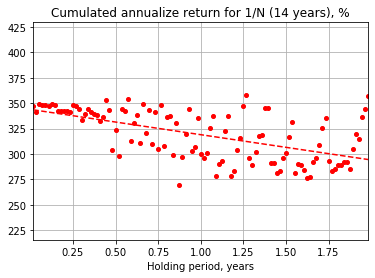

In [56]:
plt.plot(p_hor, p_cum, '.', markersize=8, color='red')

x,y = np.unique(p_hor), np.poly1d(np.polyfit(p_hor, p_cum, 1))
plt.plot(x, y(x), '--', color='red')

plt.xlim(min(p_hor), max(p_hor))
plt.ylim(0.8*min(p_cum), 1.2*max(p_cum))

plt.xlabel('Holding period, years')
plt.title('Cumulated annualize return for 1/N (14 years), %')

plt.grid(True)
plt.show()

Metrics vice horizon for 1/N portfolio with rebalancing:

In [57]:
port_ret, port_std, port_hold, port_var  = [], [], [], []
delta = int(round(0.25*scale))

for j in range(9):  
    
    df_pl = []
    
    for i in range(scale):
        df_p = df.iloc[::delta].pct_change(periods=1).dropna(axis = 0)
        df_p = 100*((0.25*df_p.sum(axis=1)+1)[i:(i+j)].product()-1)
        df_pl.append(df_p)
        
    port_ret.append(statistics.median(df_pl))
    port_std.append(statistics.stdev(df_pl))
    port_var.append(np.quantile(([abs(x) for x in df_pl if x <= 0]), p))
    
    port_hold.append(j/4)

Return vice horizon for 1/N with rebalancing and without one:

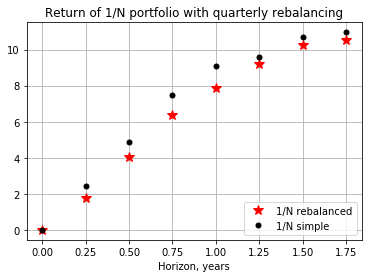

In [58]:
plt.plot(port_hold[:-1], port_ret[:-1], '*', markersize=10, color='red', label='1/N rebalanced')
plt.plot(df_hor[::delta], p_med[::delta], '.', label='1/N simple', color='black', markersize=10)

plt.title('Return of 1/N portfolio with quarterly rebalancing')
plt.xlabel('Horizon, years')
plt.legend(loc='lower right')

plt.grid(True)
plt.show()

Value at risk vice horizon for 1/N portfolio with rebalancing and without one:

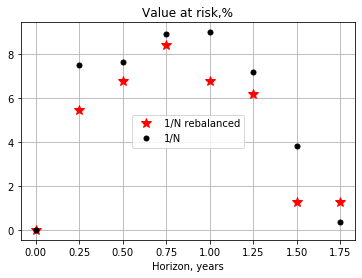

In [59]:
plt.plot(port_hold[:-1], port_var[:-1], '*', markersize=10, color='red', label='1/N rebalanced')
plt.plot(df_hor[::delta], p_var[::delta], '.', label='1/N', color='black', markersize=10)

plt.title('Value at risk,%')
plt.xlabel('Horizon, years')
plt.legend(loc='center')

plt.grid(True)
plt.show()

Return/Risk vice horizon for 1/N portfolio with rebalancing and simple 1/N: 

In [60]:
# z = [wrd_div(x,y) for x, y in zip(port_ret, port_var)][1:]
# t = [wrd_div(x,y) for x, y in zip(p_med, p_var)][::delta][1:]

# plt.plot(port_hold[1:][:-1], z[:-1], '*', label='1/N reb.', color='red', markersize=10) 
# plt.plot(df_hor[::delta][1:], t, '.', label='1/N', color='black', markersize=10)

# plt.title('Return/Risk')
# plt.xlabel('Horizon, years')
# plt.legend(loc='center')

# plt.grid(True)
# plt.show()